### This notebook is for reproducing the paper results' subsection "Optimal $\gamma$-fused structure-function modular organization" and generate the panels of the figure S1. The goal of the notebook is to test different initial parcellations (iPAs), and comparing the results. We will select for the rest of the analysis the optimal parcellation (oPA) that gives the best $\chi$ results.

First, is needed to build the trees. You can use the ones builded by us or build your own trees using the script `src/build_tree.py`. The function can be used as follows:

```python3 src/build_tree.py /path/to/your/project CONN_SIZE LOWER_LEVEL UPPER_LEVEL tree_class```

where `CONN_SIZE` is the number of nodes of your connectomes, `LOWER_LEVEL` and `UPPER_LEVEL` are the lower and upper levels of the tree to be built, and `tree_class` has two options: 
* `full` define levels with all the modules, e.g. level 3 will have 3 modules and level 4 will have 4 modules
* `reduced` define levels with unique modules, i.e. level 4 will have two modules equal to the level 3 so them will not be included.


In [1]:
import numpy as np
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

This code runs the same procedure for every $\gamma$ and every iPA. For each pair, the cross-modularity ($\chi$) is computed and stored in a dataframe, for a level-span from 2 to 120 levels, as the maximum $\chi$ is found in this range.

In [2]:
project_path = "/workspaces/bha2"
conn_sizes = [183, 391, 568, 729, 964, 1242, 1584, 1795, 2165]
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

LVLMIN = 2
LVLMAX = 120

df_full = []
df_max = []

for conn_size in conn_sizes:
    #As in the previous notebook, we load the data and compute the connectome average (or load it if it has been already computed)
    if os.path.exists(
        os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")
    ):
        fcm = np.load(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")
        )
        scm = np.load(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy")
        )
        print("fcm and scm loaded from tmp folder")
    else:
        sc_group = load_data(
            os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
        )
        fc_group = load_data(
            os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
        )
        fcm, scm = connectome_average(fc_group, sc_group)
        np.save(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm
        )
        np.save(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm
        )
    # We remove the ROIs that have no connections in the structural connectome and the functional connectome
    zero_rows_sc = np.where(~scm.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
    density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
        len(scm_nonzero.flatten())
    )
    fcm_thr = density_threshold(fcm_nonzero, density)
    zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
        zero_rows_fc, fcm_thr, scm_nonzero
    )
    # And binarize both connectomes
    fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
    scm_bin = np.where(scm_nonzero > 0, 1, 0)

    crossmod_gammas = np.empty((LVLMAX - LVLMIN, len(gammas_vec)))
    for g in gammas_vec:
        tree = json.loads(
            open(
                os.path.join(
                    project_path,
                    "data",
                    "processed",
                    "n" + str(conn_size),
                    "tree_g_" + str(g) + ".json",
                )
            ).read()
        )
        # We compute the cross-modularity for each level of the dendrogram and gamma
        crossmod = []
        mod_sc = []
        mod_fc = []
        sim_lvl = []
        for l in range(LVLMIN, LVLMAX):
            level, labels = level_from_tree(tree, l)
            roi_size = []
            for idx, rois in enumerate(level):
                roi_size.append(len(rois))
            T = T_from_level(level)
            sim = np.nanmean(similarity_level(fcm_nonzero, scm_nonzero, level))
            mod_sc_lvl = modularity(scm_nonzero, T)
            mod_fc_lvl = modularity(fcm_nonzero, T)
            c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
            crossmod.append(c)

        # We store all the cross-modularity values for each gamma and each initial parcellation size
        df_full.append(pd.DataFrame(np.vstack((np.array(crossmod), 
                            np.array([g] * len(crossmod)),
                            np.array([conn_size] * len(crossmod)))).T, 
                            columns=[r"$\chi$", r"$\gamma^*$", "Initial parcellation size (#ROIs)"]))
        # We store the cross-modularity values for each gamma in a matrix to find the optimal gamma
        crossmod_gammas[:, gammas_vec.index(g)] = crossmod

    # We find the optimal gamma for each initial parcellation size
    x, y = np.where(crossmod_gammas == np.nanmax(crossmod_gammas))
    # We only store in a dataframe the cross-modularity values for the optimal gamma (the one that maximizes the cross-modularity)
    df_max.append(pd.DataFrame(np.vstack((crossmod_gammas[:, y[0]], 
                        np.array([gammas_vec[y[0]]] * len(crossmod_gammas[:, y[0]])), 
                        np.array([conn_size] * len(crossmod_gammas[:, y[0]])))).T, 
                        columns=[r"$\chi$", r"$\gamma^*$", "Initial parcellation size (#ROIs)"]))
    
df_full = pd.concat(df_full)
df_max = pd.concat(df_max)
df_full["Initial parcellation size (#ROIs)"] = df_full["Initial parcellation size (#ROIs)"].astype(int)
df_max["Initial parcellation size (#ROIs)"] = df_max["Initial parcellation size (#ROIs)"].astype(int)

fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder


A boxplot is then generated for each $\gamma$ in where the maximum $\chi$ is found ($\gamma^{*}$), and the iPA that gives the best results is selected (in this case the parcellation with #2165 ROIs). The figure is saved in `bha2/data/figures`.

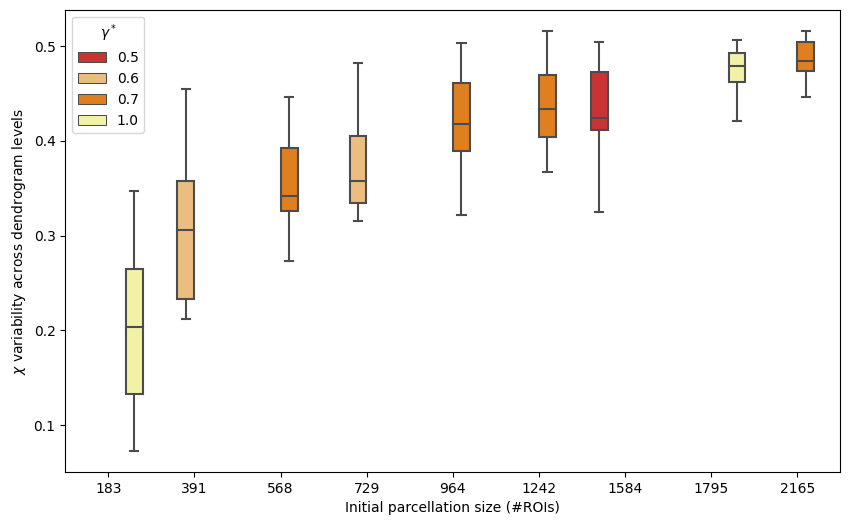

In [3]:
plt.figure(figsize=(10, 6))
max_gammas = np.where(np.in1d(gammas_vec, np.unique(df_max[r"$\gamma^*$"])))
palette_paired = sns.color_palette("Paired", len(gammas_vec))
palette_max_gammas = [palette_paired[i] for i in max_gammas[0]]
sns.boxplot(x="Initial parcellation size (#ROIs)", y=r"$\chi$", hue=r"$\gamma^*$", data=df_max, showfliers=False, palette=palette_max_gammas)
plt.ylabel(r"$\chi$" + " variability across dendrogram levels")
plt.savefig(
    os.path.join(
        project_path, "data", "figures", "initial_parcellation_selection.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

Looking to the boxplot, we can see that the best results are obtained for $\gamma=0.7$ when using the iPA with #2165 ROIs

In [4]:
CONN_SIZE = 2165

Now, we are going to represent a heatmap with all the $\chi$ values for each $\gamma$ for the iPA with #2165. The figure is saved in `bha2/data/figures`.

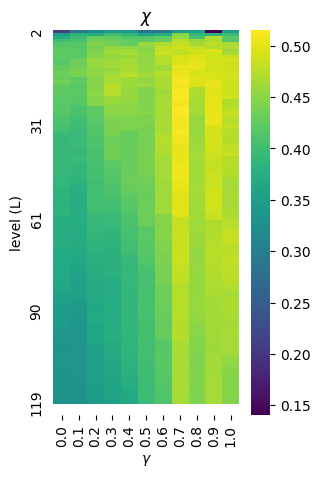

In [5]:
#First we have to filter the full dataframe and pivot the df to have a matrix
df_best_iPA = df_full[df_full["Initial parcellation size (#ROIs)"] == 2165].drop(columns=["Initial parcellation size (#ROIs)"])
df_best_iPA_mat = df_best_iPA.pivot(columns=r"$\gamma^*$", values=r"$\chi$")

#For making the visualization easier, we filter the number of y-ticks that appear in the heatmap, getting only 4 ticks
all_yticks = np.arange(LVLMIN, LVLMAX)
desired_yticks = [0, len(all_yticks) // 4, len(all_yticks) // 2, 3*len(all_yticks) // 4, len(all_yticks) - 1]

plt.figure(figsize=(3, 5))
h = sns.heatmap(
    df_best_iPA_mat, 
    cmap="viridis",
    xticklabels=np.around(np.arange(0, 1.1, 0.1), 2),
    yticklabels=[all_yticks[i] if i in desired_yticks else '' for i in range(len(all_yticks) + len(desired_yticks) - 1)]
    )
_ = h.set(xlabel=r"$\gamma$", ylabel="level (L)")
_ = h.set_title(r"$\chi$")
_ = h.tick_params(left=False)

plt.savefig(
    os.path.join(
        project_path, "data", "figures", "oPA_xmod.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

We get the level and $\gamma$ for the maximum $\chi$.

In [15]:
x, y = np.where(df_best_iPA_mat.values == np.nanmax(df_best_iPA_mat.values))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(LVLMIN, LVLMAX)
opt_gamma = round(gammas_vec[y][0], 2)
opt_level = levels_vec[x][0]

Finally, we generate the optimal parcellation (oPA) image, and save it in `bha2/data/processed/CONN_SIZE`.

In [16]:
CONN_SIZE = 2165

tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "processed",
            "n" + str(CONN_SIZE),
            "tree_g_" + str(opt_gamma) + ".json",
        )
    ).read()
)
# We not include such modules with less than 5 ROIs, as we want to study deeply the connections inside a module.
SM_THRESH = 5
lvl = opt_level
level, labels = level_from_tree(tree, lvl)

initial_parcellation = nib.load(os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "initial_parcellation.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

optimal_parcellation = np.zeros((initial_parcellation_data.shape[0], initial_parcellation_data.shape[1], initial_parcellation_data.shape[2]))

idx = 0
roi_size = []
for rois in level:
    if len(rois) > SM_THRESH:
        roi_size.append(len(rois))
        mod = get_module_vol(initial_parcellation, rois, idx + 1)
        optimal_parcellation = optimal_parcellation + mod.astype(int)
        idx += 1
optimal_parcellation_img = nib.Nifti1Image(optimal_parcellation, affine=initial_parcellation.affine)
nib.save(
    optimal_parcellation_img,
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "optimal_parcellation.nii.gz",
    ),
)